## 평균 이동
[평균 이동의 개요]
1. 중심을 군집의 중심으로 움직이며 군집화 수행.
2. 가장 집중적으로 데이터가 모인 점을 군집 중심저으로 선정하고 KDE를 이용
3. 주변 데이터와의 거리 값을 KDE 함수 값으로 입력한 뒤 반환 값을 현위치에서 업데이트
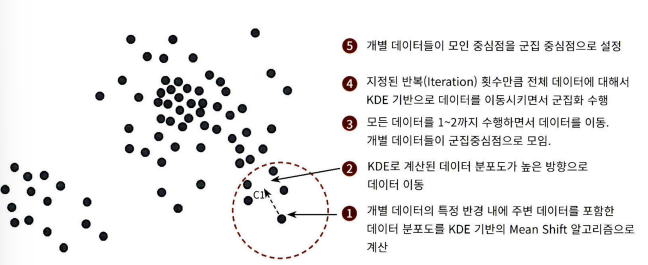

- KDE : 커널 함수를 통해 어떤 변수의 확률밀도함수를 추정하는 방법
- 관측 데이터 각각에 커널 함수를 적용한 후 모두 더하고 데이터 건수로 나누어 확률밀도함수 추정

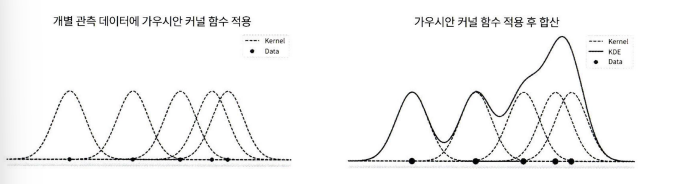
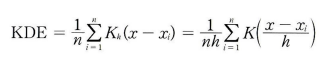

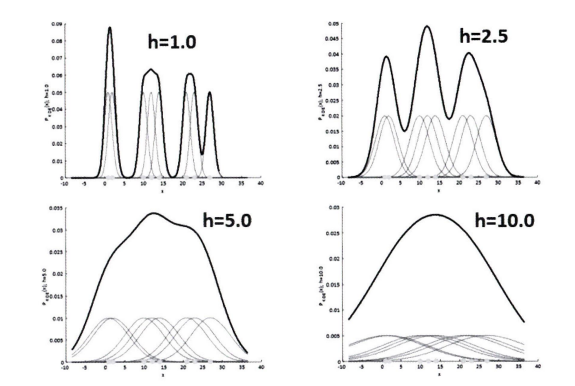
- 대역폭이 클수록 평활화된 KDE로 인해 적은 군집 중심점을 가짐
- 평균 이동 군집화는 군집의 개수를 지정하지 않으며 대역폭의 크기에 따라 군집화 수행
- 최적의 대역폭 계산을 위한 estimate_bandwidth() 함수 이용

In [2]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift
X, y = make_blobs(n_samples = 200, n_features = 2, centers = 3, cluster_std = 0.7, random_state = 0)
meanshift = MeanShift(bandwidth = 0.8)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형 : ', np.unique(cluster_labels))

cluster labels 유형 :  [0 1 2 3 4 5]


In [3]:
meanshift = MeanShift(bandwidth = 1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형 :', np.unique(cluster_labels))

cluster labels 유형 : [0 1 2]


In [4]:
from sklearn.cluster import estimate_bandwidth
bandwidth = estimate_bandwidth(X)
print('bandwidth 값 : ', round(bandwidth, 3))

bandwidth 값 :  1.816


In [31]:
import pandas as pd
clusterDF = pd.DataFrame(data = X, columns = ['ftr1', 'ftr2'])
clusterDF['target'] = y
# estimate bandwidth()로 최적의 bandwidth 계산
best_bandwidth = estimate_bandwidth(X)
meanshift = MeanShift(bandwidth = best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('clusterf labels 유형 : ', np.unique(cluster_labels))

# 3개의 군집으로 잘 군집화

clusterf labels 유형 :  [0 1 2]


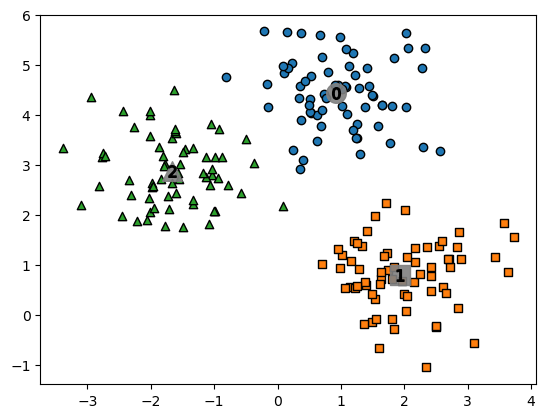

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
clusterDF['meanshift_label'] = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers=  ['o', 's', '^', 'x', '*']
for label in unique_labels :
    label_cluster = clusterDF[clusterDF['meanshift_label'] == label]
    center_x_y = centers[label]
    # 군집별로 다른 마커로 산점도 적용
    plt.scatter(x = label_cluster['ftr1'], y = label_cluster['ftr2'], edgecolor= 'k', marker=markers[label])
    # 군집별 중심 표현
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color = 'grey', alpha = 0.9, marker = markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color= 'k', edgecolor = 'k', marker='$%d$' % label)

plt.show()

In [7]:
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  67
1       1                  67
2       2                  66
Name: count, dtype: int64


### GMM (Gaussian Mixture Model)
- 군집화를 적용하고잔 하는 데이터가 여러 개의 가우시안 분포를 가진 데이터 집합이 섞여서 생성된 것이라는 가정하에 군집화 수행
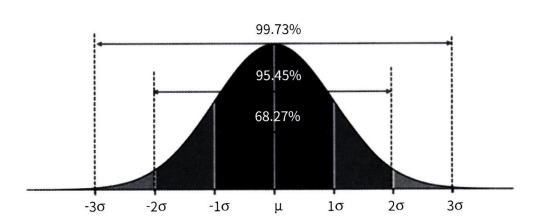
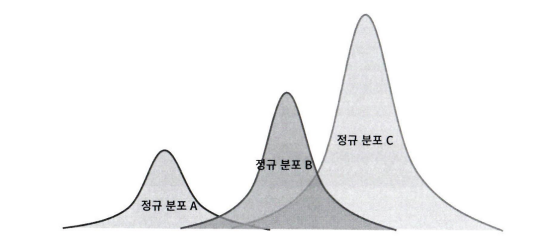
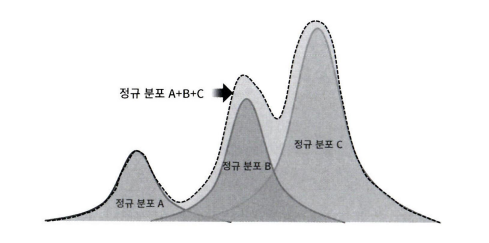
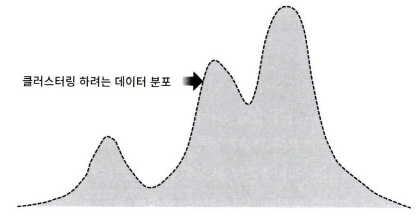
- 서로 다른 정규 분포 형태를 가진 여러 확률 분포 곡선으로 이루어져 있고 서로 다른 정규 분포에 기반한 군집화 수행
1. 개별 정규분포의 평균과 분산 추정
2. 각 데이터가 어떤 정규 분포에 해당되는지의 확률

#### GMM을 이용한 붓꽃 데이터 세트 군집화 

In [32]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
# 좀더 편리한 데이터 핸들링 위해 df 변환
irisDF =pd.DataFrame(data = iris.data, columns = feature_names)
irisDF['target'] = iris.target

# n_components: 가우시안 혼합의 총 개수

In [10]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 3, random_state = 0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)
# 군집화 결과를 irisDF의 'gmm_cluster' 칼럼 명으로 저장
irisDF['gmm_cluster'] = gmm_cluster_labels
irisDF['target'] = iris.target
# target값에 따라 gmm_cluster 값이 어떻게 매핑됐는지 확인 
iris_result = irisDF.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

C:\Users\gyw78\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


target  gmm_cluster
0       0              50
1       2              45
        1               5
2       1              50
Name: count, dtype: int64


#### GMM과 K-평균의 비교
- KMeans : 원형 범위에서 군집화 수행
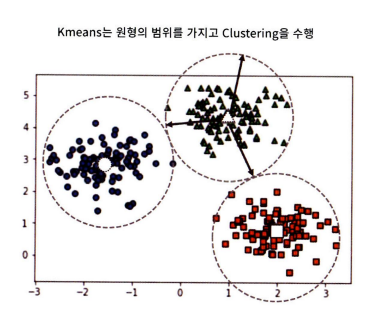

In [15]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, random_state = 0).fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
irisDF['kmeans_cluster'] = kmeans_cluster_labels
iris_result = irisDF.groupby(['target'])['kmeans_cluster'].value_counts()
print(iris_result)

C:\Users\gyw78\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


target  kmeans_cluster
0       1                 50
1       0                 48
        2                  2
2       2                 36
        0                 14
Name: count, dtype: int64


In [18]:
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()


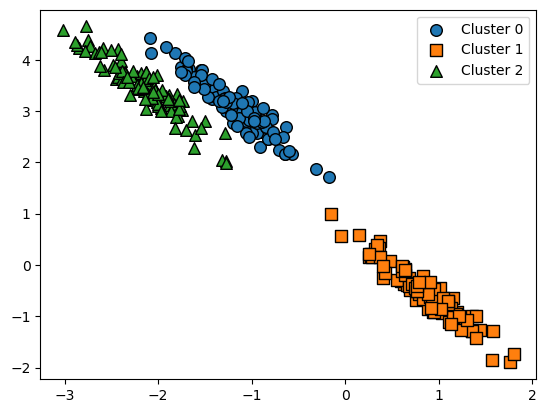

In [19]:
from sklearn.datasets import make_blobs

# make_blobs로 300개의 데이터 세트, 3개의 군집 세트, cluster_std = 0.5를 만듦
X, y = make_blobs(n_samples = 300, n_features = 2, centers =3, cluster_std=0.5,
                 random_state = 0)
# 길게 늘어난 타원형의 데이터세트를 생성하기 위해 변환
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_ansio = np.dot(X, transformation)
# feature dataset과 make_blobs의 y 결괏값 df로 저장
clusterDF = pd.DataFrame(data = X_ansio,columns = ['ftr1', 'ftr2'])
clusterDF['target'] = y
# 생성된 데이터 세트를 target별로 다른 마커로 표시해 시각화
visualize_cluster_plot(None, clusterDF, 'target', iscenter = False)

C:\Users\gyw78\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


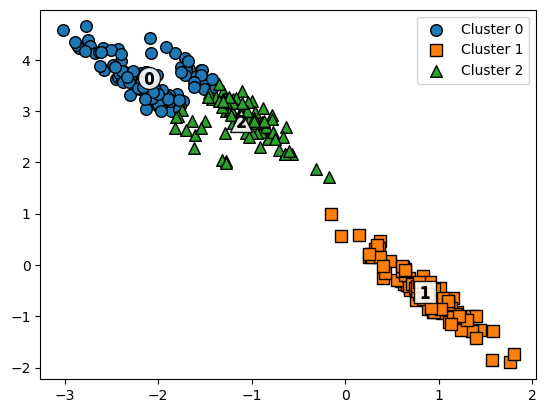

In [25]:
# 3개의 군집 기반 kmeans를 x_ansio 데이터 세트에 적용
kmeans = KMeans(3, random_state=0)
kmeans_label = kmeans.fit_predict(X_ansio)
clusterDF['kmeans_label'] = kmeans_label

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label',iscenter=True)

kmeans로 군집화를 수행할 경우 원형 영역 위치로 개별 군집화가 되며 원하는 방향으로 구성되지 않음. 길쭉한 방향으로 데이터가 밀접한 경우 최적의 밀집화가 어려움

C:\Users\gyw78\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


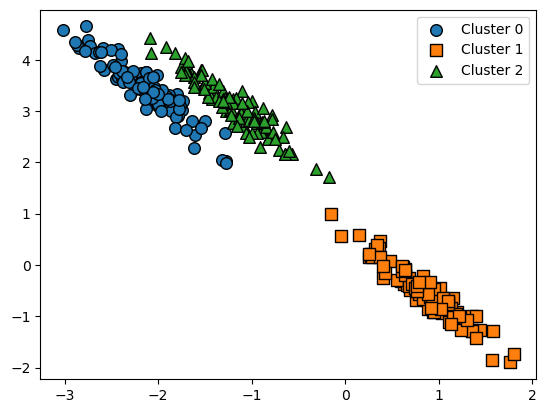

In [29]:
# 3개의 n_components 기반 gmm을 x_ansio 데이터 세트에 적용
gmm = GaussianMixture(n_components = 3, random_state=0)
gmm_label = gmm.fit(X_ansio).predict(X_ansio)
clusterDF['gmm_label'] = gmm_label

visualize_cluster_plot(kmeans, clusterDF, 'gmm_label',iscenter=False)

In [30]:
print('### kmeans clustering ###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('\n### Gaussian Mixture Clustering ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

### kmeans clustering ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: count, dtype: int64

### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: count, dtype: int64
